In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import folium

url_housing_data = "https://raw.githubusercontent.com/joos2010kj/Links/master/data.csv?token=AEXJEVVXZ3N4432GIAX3NTK57ANTW"
url_US_zipcodes = "https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data"

df = pd.read_csv(url_housing_data)
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


In [33]:
# Normalizing dataset
def norm(arr):
  minimum = min(arr)
  maximum = max(arr)

  return [(i - minimum) / (maximum - minimum) for i in arr]

# Determining the power of the price
def color_code(p):
  r, g, b = (0, 0, 0)

  # yellow
  if p == 0.5:
    return (255, 255, 0)

  # redder
  elif p > 0.5:
    return (255, 255 / p - 255, 0)

  # greener
  else:
    return (255 + 2 * (p - 0.5) * 255, 255, 0)


# Getting rid of outliers by removing the top 2.5% and bottom 2.5% of data
normalized_df = df[df['price'].between(df['price'].quantile(0.025), 
                                       df['price'].quantile(0.975))]

# The number of data samples
COUNT = len(normalized_df)

normalized_df = normalized_df.reset_index()

# For normalization, substituting rows with an empty 'yr_renovated' value
#   for a 'yr_built' value. 
normalized_df['yr_renovated'] = [normalized_df['yr_built'][i] \
                                 if normalized_df['yr_renovated'][i] == 0 \
                                 else normalized_df['yr_renovated'][i] \
                                 for i in range(COUNT)]

# Keeping the non-normalized year as reference
normalized_df['non_normalized_yr'] = normalized_df['yr_renovated']

# Combining the sqft values (internal) of each house
normalized_df['sqft_house'] = [normalized_df['sqft_living'][i] +
                               normalized_df['sqft_above'][i] +
                               normalized_df['sqft_basement'][i]
                               for i in range(COUNT)]

# Grouping area code
zipcode = []

for i in normalized_df['statezip']:
   code = re.findall(r'^([A-Z]{2}) ([0-9]{5})$', i)
   zipcode.append(code[0][1])

normalized_df['zip'] = zipcode

# Fields that will be normalized
normalized_fields = ['price', 'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 
                     'view', 'condition', 'yr_built', 'yr_renovated', 
                     'sqft_house']

# Normalization
for i in normalized_fields:
  normalized_df[i] = norm(normalized_df[i])

# Color coding the price of the house
normalized_df['price_color'] = [color_code(i) for i in normalized_df['price']]

# Removing the unused fields
normalized_df = normalized_df.drop(['waterfront', 'sqft_living', 'sqft_above',
                                    'sqft_basement', 'index', 'country', 
                                    'statezip'], axis=1)

# Collecting US Zipcode data
zipcodes = pd.read_csv(url_US_zipcodes)
zipcodes.columns = ["zip","lat", "lon"]
normalized_df["zip"] = normalized_df['zip'].astype(int)

# Merging the zipcode data with df
normalized_df = pd.merge(zipcodes, normalized_df, how="inner", on="zip")

# Rearranging the columns
normalized_df = normalized_df[['price', 'bedrooms', 'bathrooms', 
                               'sqft_lot', 'sqft_house', 'floors', 'view', 
                               'condition', 'non_normalized_yr', 'yr_built', 
                               'yr_renovated', 'street', 'city', 'zip', 'lat', 
                               'lon', 'price_color']]

normalized_df

,price,bedrooms,bathrooms,sqft_lot,sqft_house,floors,view,condition,non_normalized_yr,yr_built,yr_renovated,street,city,zip,lat,lon,price_color
0,0.065975,0.333333,0.304348,0.008074,0.223022,0.0,0.0,0.50,1984,0.736842,0.736842,30001-30021 55th Pl S,Auburn,98001,47.310617,-122.263291,"(33.64714603409931, 255, 0)"
1,0.151223,0.444444,0.347826,0.016887,0.332374,0.0,0.0,1.00,1965,0.570175,0.570175,31607-31633 44th Ave S,Auburn,98001,47.310617,-122.263291,"(77.12379540400298, 255, 0)"
2,0.030393,0.333333,0.304348,0.006611,0.189928,0.0,0.0,0.75,1992,0.666667,0.807018,30020 43rd Pl S,Auburn,98001,47.310617,-122.263291,"(15.500370644922157, 255, 0)"
3,0.091920,0.333333,0.434783,0.003384,0.176978,0.4,0.0,0.50,2000,0.877193,0.877193,5146 S 303rd Pl,Auburn,98001,47.310617,-122.263291,"(46.87916975537436, 255, 0)"
4,0.251297,0.444444,0.478261,0.019148,0.328921,0.4,0.0,0.50,2014,1.000000,1.000000,31898 50th Pl S,Auburn,98001,47.310617,-122.263291,"(128.16160118606376, 255, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4365,0.280949,0.444444,0.391304,0.006905,0.375540,0.2,0.5,0.75,1935,0.307018,0.307018,2550 Westmont Way W,Seattle,98199,47.651371,-122.407349,"(143.28391401037806, 255, 0)"
4366,0.317272,0.333333,0.304348,0.000371,0.161151,0.4,0.0,0.50,2008,0.947368,0.947368,4304B 36th Ave W,Seattle,98199,47.651371,-122.407349,"(161.80874722016307, 255, 0)"
4367,0.191994,0.333333,0.478261,0.059602,0.320863,0.2,0.0,0.50,2009,0.956140,0.956140,69506 NE Money Creek Rd,Skykomish,98288,47.661553,-121.278786,"(97.91697553743512, 255, 0)"
4368,0.121572,0.333333,0.304348,0.008627,0.143885,0.0,0.0,0.75,1983,0.728070,0.728070,99 17th Ave,Milton,98354,47.251994,-122.317289,"(62.001482579688656, 255, 0)"


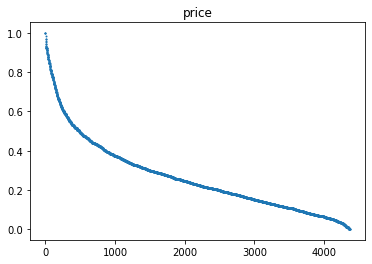

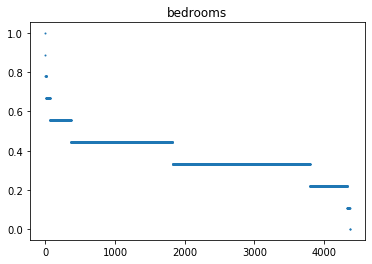

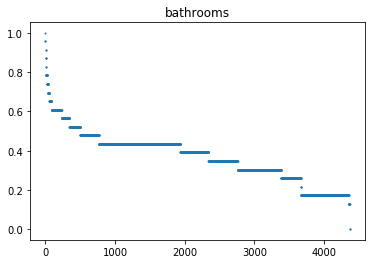

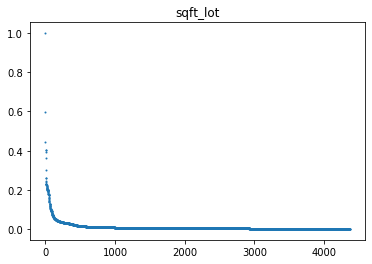

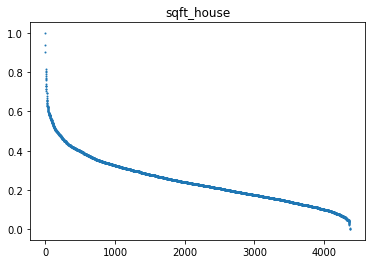

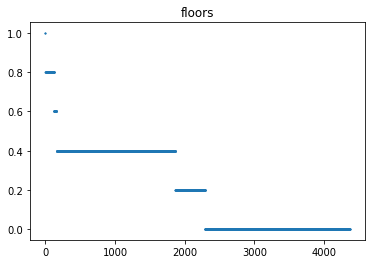

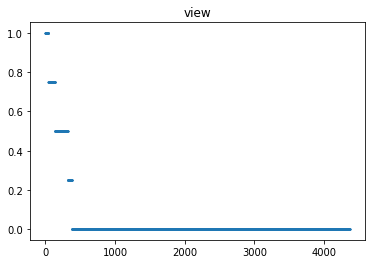

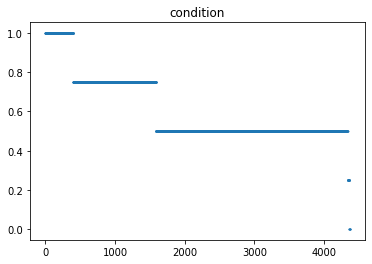

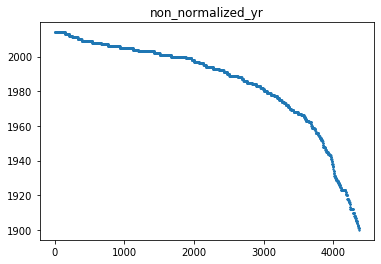

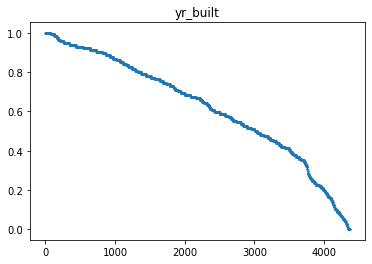

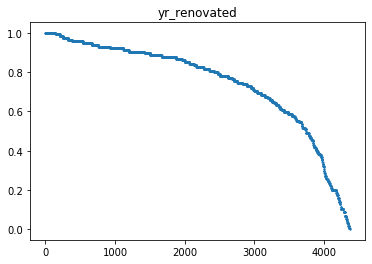

In [34]:
for field in normalized_df.columns[:-6]:
  temp = normalized_df.sort_values(by=field, ascending=False)
  plt.figure(np.random.randint(1000))
  plt.title(field)
  plt.scatter(np.arange(COUNT), temp[field], s=1)

In [57]:
def standardize(arr):
  arr = np.array(arr)
  return (arr - arr.mean()) / arr.std()

def dist(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

def avg(xys):
    xs = [i[0] for i in xys]
    ys = [i[1] for i in xys]
    
    return (np.mean(xs), np.mean(ys))

def k_means(xs, ys, k=5, epoch=10):
    least_variance = float('inf')
    best_clusters = []
    best_centroids = []
    size = len(xs)
    
    for ep in range(epoch):
        centroids = [(xs[i], ys[i]) for i in np.random.choice(size, k)]
        clusters = [[] for i in range(k)]
        
        for ind in range(size):
            x = xs[ind]
            y = ys[ind]
            
            point = (x, y)
            closest = float('inf')
            closest_centroid = -1
            
            for centroid_ind in range(len(centroids)):
                distance = dist(centroids[centroid_ind][0], 
                                centroids[centroid_ind][1], 
                                point[0], point[1])
                
                if distance < closest:
                    closest = distance
                    closest_centroid = centroid_ind
                    
            clusters[closest_centroid].append(point)
            centroids[closest_centroid] = avg(clusters[closest_centroid])
        
        variance = 0
        
        for ind in range(k):
            for pt in clusters[ind]:
                variance += dist(pt[0], pt[1], 
                                 centroids[ind][0], centroids[ind][1])
        
        if variance < least_variance:
            best_clusters = clusters
            least_variance = variance
            best_centroids = centroids
        
        print(str((ep / epoch) * 100) + "%")
            
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown']
    circles = []
    order = {}
    
    for i in range(k):
        xs = [x[0] for x in best_clusters[i]]
        ys = [y[1] for y in best_clusters[i]]
        centroid = best_centroids[i]
        
        longest_distance = 0
        
        for j in range(len(xs)):
            x = xs[j]
            y = ys[j]
            distance = dist(x, y, centroid[0], centroid[1])
            
            if distance > longest_distance:
                longest_distance = distance
          
        order[i] = longest_distance

    
    order = sorted(order.items(), key=lambda x: x[1])
    
    for ind in range(k): 
        elm = order[ind][0]
        folium.Popup(best_centroids[elm][0], best_centroids[elm][1], ind + 1)

        folium.Circle(radius=10000,
                            color=colors[ind],
                            fill=True,
                            location=[best_centroids[elm][0], 
                                      best_centroids[elm][1]],
                            popup='Congestedness Rank: {}'.format(int(ind) + 1)
                            ).add_to(visual_map)
    

def find_most_dangerous_regions_in_washington(separated_by=3, accuracy=10):
    k_means(normalized_df['lat'].values, 
            normalized_df['lon'].values, 
            min(separated_by, 7), 
            max(accuracy, 10))
    
visual_map = folium.Map(location=[47.25, -122.32], zoom_start=9)

find_most_dangerous_regions_in_washington(5, 30)

visual_map

0.0%
3.3333333333333335%
6.666666666666667%
10.0%
13.333333333333334%
16.666666666666664%
20.0%
23.333333333333332%
26.666666666666668%
30.0%
33.33333333333333%
36.666666666666664%
40.0%
43.333333333333336%
46.666666666666664%
50.0%
53.333333333333336%
56.666666666666664%
60.0%
63.33333333333333%
66.66666666666666%
70.0%
73.33333333333333%
76.66666666666667%
80.0%
83.33333333333334%
86.66666666666667%
90.0%
93.33333333333333%
96.66666666666667%
